<a href="https://colab.research.google.com/github/yrodriguezmd/Surgical_instruments/blob/main/Sets/Set_1/notebooks/Set_1_pseudolabel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use COCO-pretrained VFNet to generate pseudolabels from Set_1

In [ ]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
!bash install_colab.sh

In [2]:
exit()

In [ ]:
import icevision

In [2]:
from icevision.all import *
print('icevision v',icevision.__version__)
print('torch v',torch.__version__)
print('torchvision v',torchvision.__version__)

icevision v 0.10.0a1
torch v 1.9.0+cu111
torchvision v 0.10.0+cu111


Set_1 unlabelled dataset

In [ ]:
!git clone https://github.com/yrodriguezmd/Surgical_instruments.git

In [5]:
!ls Surgical_instruments/Sets/Set_1

annotated  notebooks  pseudolabel  raw_images  README.md


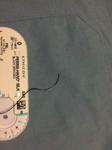

In [6]:
image_path = Path('Surgical_instruments/Sets/Set_1/raw_images')

img_files = get_image_files(image_path)

img = PIL.Image.open(img_files[0]) ##
img = img.convert('RGB')

img.to_thumb(150,150)

In [7]:
# using model pretrained on coco
CLASSES = ('person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
               'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
               'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog',
               'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
               'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
               'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
               'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
               'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
               'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
               'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
               'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop',
               'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
               'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
               'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush')
class_map = ClassMap(CLASSES)
len(class_map)

81

VFNet model

In [ ]:
from icevision.models import *

model_type = models.mmdet.vfnet ##
backbone = model_type.backbones.resnet50_fpn_mstrain_2x ##

model = model_type.model(backbone = backbone(pretrained=True), num_classes = len(class_map))

In [9]:
backbone.__dict__

{'config_path': Path('/root/.icevision/mmdetection_configs/mmdetection_configs-2.16.0/configs/vfnet/vfnet_r50_fpn_mstrain_2x_coco.py'),
 'model_name': 'vfnet',
 'pretrained': True,
 'weights_url': 'https://openmmlab.oss-cn-hangzhou.aliyuncs.com/mmdetection/v2.0/vfnet/vfnet_r50_fpn_mstrain_2x_coco/vfnet_r50_fpn_mstrain_2x_coco_20201027-7cc75bd2.pth'}

Inference

In [11]:
model.eval()

imgs_array = [PIL.Image.open(file) for file in img_files]

imgs_array = [image.convert('RGB') for image in imgs_array]

img_size = 384 

valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(img_size), tfms.A.Normalize()])

infer_ds = Dataset.from_images(imgs_array, valid_tfms, class_map = class_map)

In [ ]:
infer_dl = model_type.infer_dl(infer_ds, batch_size=4, shuffle=False)

preds_saved = model_type.predict_from_dl(model, infer_dl,
                                          keep_images=True,) 

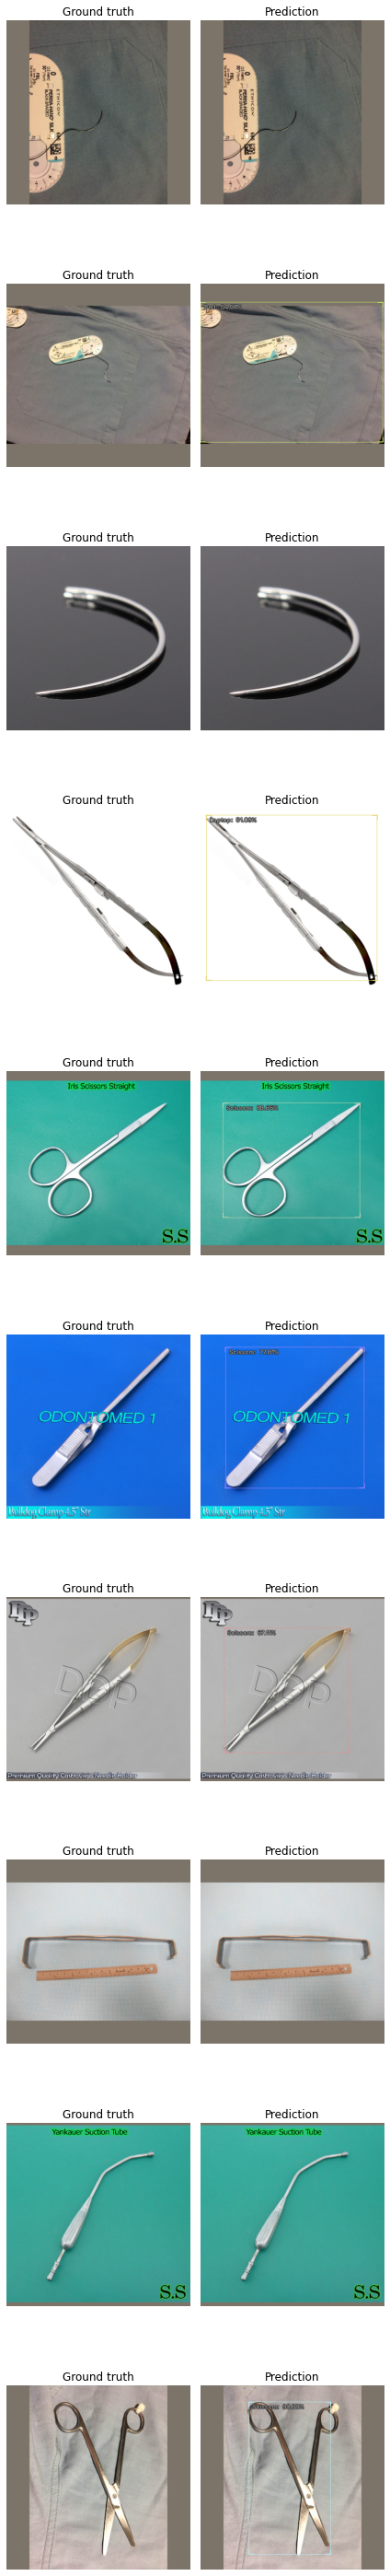

In [13]:
show_preds(preds = preds_saved[0:10])

Generate annotation file

In [21]:
for pred in preds_saved:
  pred.add_component(FilepathRecordComponent())

for _ in range(len(preds_saved)): 
  preds_saved[_].set_filepath(img_files[_]) 

# initial annotation
conv = convert_preds_to_coco_style(preds_saved)

In [15]:
# additional annotation info needed
add_info = {
    "info": {
    "description": "Surgery Instruments",
    "url": "http://cocodataset.org",
    "version": "1.0",
    "year": 2021,
    "contributor": "MR",
    "date_created": "2021/09/27"
    },
  "categories": [
                 ## adjusted to 80 classes, 
                 ## limiting categories
    {
      "supercategory": "kitchen",
      "id": 44,
      "name": "knife"
    },
    {
      "supercategory": "indoor",
      "id": 77,
      "name": "scissors"
    }
    ] }

In [22]:
# merge initial annotation and additional data
pseudo = {**add_info, **conv}

f = open('pseudo.json','w') 
f.write(str(pseudo)) 
f.close()

In [24]:
!ls pseudo.json

pseudo.json


In [25]:
from google.colab import files
files.download('pseudo.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(External modification of json file: replace ' with ")

Annotate and split dataset in Roboflow.